In [2]:

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import random as rd
import cv2


import wfdb

In [3]:
file = open('./mit-bih-arrhythmia-database-1.0.0/RECORDS')
records = file.readlines()
file.close()

In [3]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [12]:
good = ['N']
leftBundleBlocks = ['L']
rightBundleBlocks = ['R']
atrialContraction = ['A']
ventricularContraction = ['V']
paced = ['/']
ventricularEscape = ['E']
ventricularFlutterWave = ['!']

In [4]:
def segmentation(typeBeat):

    liste1,liste2 = [],[]

    for e in records:
        signals, fields = wfdb.rdsamp('./mit-bih-arrhythmia-database-1.0.0/' + e[0:-1]) 

        ann = wfdb.rdann('./mit-bih-arrhythmia-database-1.0.0/' + e[0:-1], 'atr')
       
        ids = np.in1d(ann.symbol, typeBeat)
        imp_beats = ann.sample[ids]
        beats = (ann.sample)
        for i in imp_beats:
            beats = list(beats)
            j = beats.index(i)
            if(j!=0 and j!=(len(beats)-1)):
                x = beats[j-1]
                y = beats[j+1]
                diff1 = abs(x - beats[j])//2
                diff2 = abs(y - beats[j])//2
                signal0 = signals[beats[j] - diff1: beats[j] + diff2, 0]
                signal1 = signals[beats[j] - diff1: beats[j] + diff2, 1]
                
                #indMax = signal0.index(np.max(np.abs(signal0)))
                indMax = np.where(np.abs(signal0) == np.max(np.abs(signal0)))
                indMid = int(len(signal0)//2)
                shift = indMax[0] - indMid
                
                signal0 = np.roll(signal0, -shift)
                signal1 = np.roll(signal1, -shift)
                
                
                if (len(signal0) < 501):
                    signal0Pad = padding(signal0,500)
                    signal1Pad= padding(signal1,500)
                else:
                    signal0Pad = signal0
                    signal1Pad = signal1
                #print(shift)
                #if shift > 0:
                 #   signal0 = np.roll(signal0, -shift)
                #elif shift < 0:
                 #   signal0 = np.roll(signal0, -shift)
                
                liste1.append(signal0Pad)
                liste2.append(signal1Pad)

    #liste1 = liste1[1:] 
    #liste2 = liste2[1:]
    return liste1,liste2

In [5]:
def padding(signal0,lmax):
    length = len(signal0)
    shift = (lmax - length)//2
    signalPadded = np.pad(signal0, (shift, shift), 'constant')
    return signalPadded

In [3]:
NORMAL = segmentation(good) 
LBB = segmentation(leftBundleBlocks)
RBB = segmentation(rightBundleBlocks)
APC = segmentation(atrialContraction)
PVC = segmentation(ventricularContraction)
VEB = segmentation(ventricularEscape)
PAB = segmentation(paced)
VFW = segmentation(ventricularFlutterWave)

NameError: name 'good' is not defined

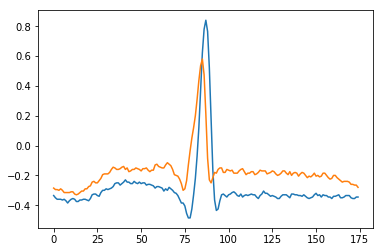

In [71]:

plt.plot(NORMAL[0][0])
plt.plot(NORMAL[1][0])



In [8]:
len(LBB)

2

In [7]:
NORMALnp = np.array(NORMAL)
LBBnp = np.array(LBB)
RBBnp = np.array(RBB)
APCnp = np.array(APC)
PVCnp = np.array(PVC)
VEBnp = np.array(VEB)
PABnp = np.array(PAB)
VFWnp = np.array(VFW)

In [ ]:
NORMALnp


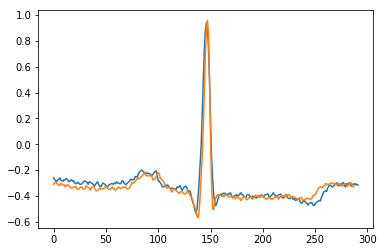

In [9]:
plt.plot(NORMALnp[0,0])
plt.plot(NORMALnp[0,1])


In [2]:
NORMALLabel = ['Normal']*len(NORMAL[0])
LBBLabel = ['LBB']*len(LBB[0])
RBBLabel = ['RBB']*len(RBB[0])
APCLabel = ['APC']*len(APC[0])
PVCLabel = ['PVC']*len(PVC[0])
VEBLabel = ['VEB']*len(VEB[0])
PABLabel = ['PAB']*len(PAB[0])
#VFWLabel = ['VFW']*len(VFW[0])

Labels =np.array(NORMALLabel + LBBLabel + RBBLabel + APCLabel + PVCLabel + VEBLabel + PABLabel)
Signals =  np.concatenate((NORMAL, LBB, RBB, APC, PVC, VEB, PAB),axis = 1)



NameError: name 'NORMAL' is not defined

In [15]:
len(Signals[1])

107612

In [ ]:
len(Signals[0]) == len(Labels)

Signals[:,0]

In [6]:
class ECGDataset(Dataset):

    def __init__(self, Dir):
        
        file = open(Dir+'RECORDS')
        records = file.readlines()
        file.close()
        
        good = ['N']
        leftBundleBlocks = ['L']
        rightBundleBlocks = ['R']
        atrialContraction = ['A']
        ventricularContraction = ['V']
        paced = ['/']
        ventricularEscape = ['E']
       # ventricularFlutterWave = ['!']
        
        NORMAL = segmentation(good) 
        LBB = segmentation(leftBundleBlocks)
        RBB = segmentation(rightBundleBlocks)
        APC = segmentation(atrialContraction)
        PVC = segmentation(ventricularContraction)
        VEB = segmentation(ventricularEscape)
        PAB = segmentation(paced)
        #VFW = segmentation(ventricularFlutterWave)
        
        
        NORMALLabel = ['Normal']*len(NORMAL[0])
        LBBLabel = ['LBB']*len(LBB[0])
        RBBLabel = ['RBB']*len(RBB[0])
        APCLabel = ['APC']*len(APC[0])
        PVCLabel = ['PVC']*len(PVC[0])
        VEBLabel = ['VEB']*len(VEB[0])
        PABLabel = ['PAB']*len(PAB[0])
       # VFWLabel = ['VFW']*len(VFW[0])

        self.Labels =np.array(NORMALLabel + LBBLabel + RBBLabel + APCLabel + PVCLabel + VEBLabel + PABLabel )
        self.Signals =  np.concatenate((NORMAL, LBB, RBB, APC, PVC, VEB, PAB),axis = 1)

        
        
        
        

    def __len__(self):
        return len(self.Signals[0])

    def __getitem__(self, idx):

        sample = {'Signals': self.Signals[:,idx], 'Label': self.Labels[idx]}

        return sample
    
    
    

In [7]:
DS = ECGDataset(Dir = './mit-bih-arrhythmia-database-1.0.0/')
sample = DS[0]

In [94]:
sample = DS[80001]

'RBB'

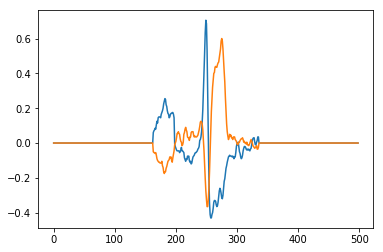

In [8]:
sample = DS[90021]
plt.plot(sample['Signals'][0])
plt.plot(sample['Signals'][1])
sample['Label']

In [57]:
i, = np.where(np.abs(sample['Signals'][0]) == np.max(np.abs(sample['Signals'][0])))
#i = list(sample['Signals'][0]).index(np.max(np.abs(sample['Signals'][0]))) # i will return index of 2, which is 1
i
#np.max(np.abs(sample['Signals'][0]))
#indice = sample['Signals'][0].index(np.max(np.abs(sample['Signals'][0])))

array([347], dtype=int64)

In [19]:
tailles = []
for sample in DS:
    longueur = len(sample['Signals'][0])
    
    if not np.any(tailles == longueur) and longueur <= 1000:
        tailles.append(longueur)
        
tailleMax = np.max(tailles)
indexMax = np.argmax(tailles)
    

In [20]:
tailleMax

200

In [155]:
sample = DS[28068]
len(sample['Signals'][0])

498

'Normal'

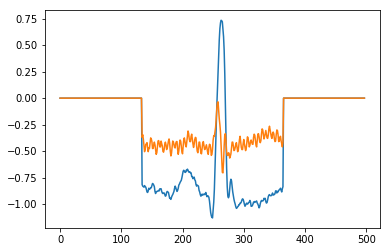

In [156]:

plt.plot(sample['Signals'][0])
plt.plot(sample['Signals'][1])
sample['Label']

In [45]:
type(DS)

__main__.ECGDataset

In [8]:
def normalize(DS):
    for sample in DS:
        sample['Signals'][0] = sample['Signals'][0][int(len(sample['Signals'][0]) /2)-100:int(len(sample['Signals'][0]) /2)+100]
        sample['Signals'][1] = sample['Signals'][1][int(len(sample['Signals'][1]) /2)-100:int(len(sample['Signals'][1]) /2)+100]
        #print(len(sample['Signals'][0]))
    return DS

DS = normalize(DS)

'LBB'

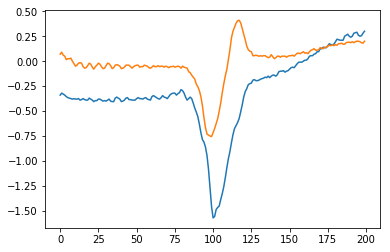

In [9]:
sample = DS[80080]
plt.plot(sample['Signals'][0])
plt.plot(sample['Signals'][1])
sample['Label']

In [10]:
class subDataSet(Dataset):
    def __init__(self, sampleList):
        
        

        self.samples = sampleList

 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        sample = {'Signals': self.samples['Signals'][idx], 'Label': self.samples['Label'][idx]}

        return sample
    

In [11]:
def createSubDataSets(trainproportion,totalDataSet):
    train = []
    test = []
    for sample in DS:
        rand = rd.random()
        if (rand < trainproportion):
            train.append(sample)
        else:
            test.append(sample)
    trainSet = subDataSet(train)
    testSet = subDataSet(test)
    return trainSet, testSet

    

In [12]:
trainSet, testSet = createSubDataSets(0.70, DS)

In [13]:
len(trainSet), len(testSet) , len(DS)
#plt.plot(sample['Signals'][0])
#plt.plot(sample['Signals'][1])
#sample['Label']

(75060, 32088, 107148)

In [15]:
# Transformation en image
def signals2Images(DS):
    count = 0
    for sample in DS:
        fig = plt.figure(frameon=False) 
        plt.plot(sample['Signals'][0])
        plt.plot(sample['Signals'][1])
        plt.xticks([]), plt.yticks([])
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        
        filename = './mit-arrhythmia-images' + '/' + sample['Label'] + '/' + str(count)+'.png'
        fig.savefig(filename)
        im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        0
        im_gray = cv2.resize(im_gray, (128, 128), interpolation = cv2.INTER_LANCZOS4)
        cv2.imwrite(filename, im_gray)
        count = count + 1
        plt.close()
        
signals2Images(DS)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>